In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ID_Quora_Paraphrasing_train.csv')
df = pd.DataFrame(data)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134084 entries, 0 to 134083
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   question_1  134084 non-null  object
 1   question_2  134084 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [ ]:
df.head()

,question_1,question_2
0,Apa beberapa teknik yoga yang baik untuk menur...,Apa asana yoga untuk menurunkan berat badan?
1,Bagaimana musik memicu emosi?,Mengapa musik bertanggung jawab untuk memicu e...
2,Apa beberapa contoh bagaimana data dan informa...,Apa perbedaan antara data dan informasi dengan...
3,Haruskah saya menggunakan papan ouija? Apakah ...,Apakah Papan Ouija benar-benar memanggil roh? ...
4,Apa saja hal-hal yang orang awam tahu tetapi j...,Apa yang diketahui oleh jutawan bahwa orang bi...


In [ ]:
df['sentence1_length'] = df['question_1'].apply(lambda x: len(x.split()))
df['sentence2_length'] = df['question_2'].apply(lambda x: len(x.split()))

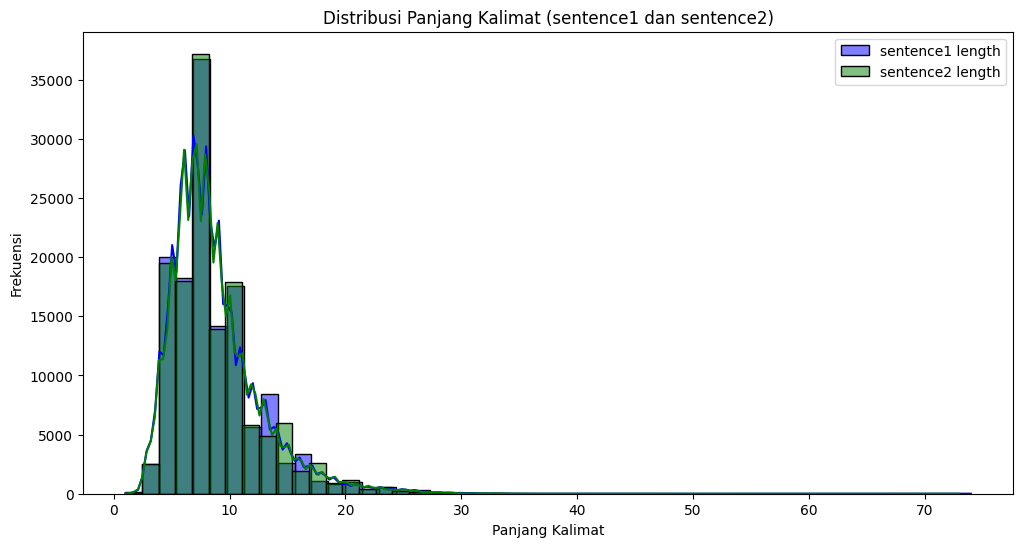

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['sentence1_length'], bins=50, kde=True, color='blue', label='sentence1 length')
sns.histplot(df['sentence2_length'], bins=50, kde=True, color='green', label='sentence2 length')
plt.legend()
plt.title('Distribusi Panjang Kalimat (sentence1 dan sentence2)')
plt.xlabel('Panjang Kalimat')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
X = df['question_1']
y = df['question_2']

In [ ]:
X.shape, y.shape

((134084,), (134084,))

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X, y]).values)  # Menggabungkan kolom untuk kosakata

In [ ]:
X_seq = tokenizer.texts_to_sequences(X)
y_seq = tokenizer.texts_to_sequences(y)

In [ ]:
# max_length = 30
vocab_size = len(tokenizer.word_index) + 1  # Menambah +1 untuk kata yang tidak dikenal
embedding_dim = 100
max_length = max(max(len(seq) for seq in X_seq), max(len(seq) for seq in y_seq))

In [ ]:
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post', truncating='post')
y_padded = pad_sequences(y_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

In [ ]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    filepath='best_model_LSTM_{val_accuracy:.4f}.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' because we want the highest val_accuracy
    verbose=1
)
# Early Stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(X_padded, y_padded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8799 - loss: 1.5050
Epoch 1: val_accuracy improved from -inf to 0.89423, saving model to best_model_LSTM_0.8942.keras
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 262s 76ms/step - accuracy: 0.8799 - loss: 1.5048 - val_accuracy: 0.8942 - val_loss: 0.7599
Epoch 2/50
3352/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8961 - loss: 0.7302
Epoch 2: val_accuracy improved from 0.89423 to 0.89865, saving model to best_model_LSTM_0.8987.keras
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 262s 78ms/step - accuracy: 0.8961 - loss: 0.7301 - val_accuracy: 0.8987 - val_loss: 0.6943
Epoch 3/50
3352/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8997 - loss: 0.6646
Epoch 3: val_accuracy improved from 0.89865 to 0.90035, saving model to best_model_LSTM_0.9003.keras
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 319s 77ms/step - accuracy: 0.8997 - loss: 0.6646 - val_accuracy: 0.9003 - val_loss: 0.6604
Epoch 4/50
3352/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 72, 100)             │       2,621,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 72, 64)              │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 72, 26215)           │       1,703,975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,103,147 (49.98 MB)

 Trainable params: 4,367,715 (16.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,735,432 (33.32 MB)

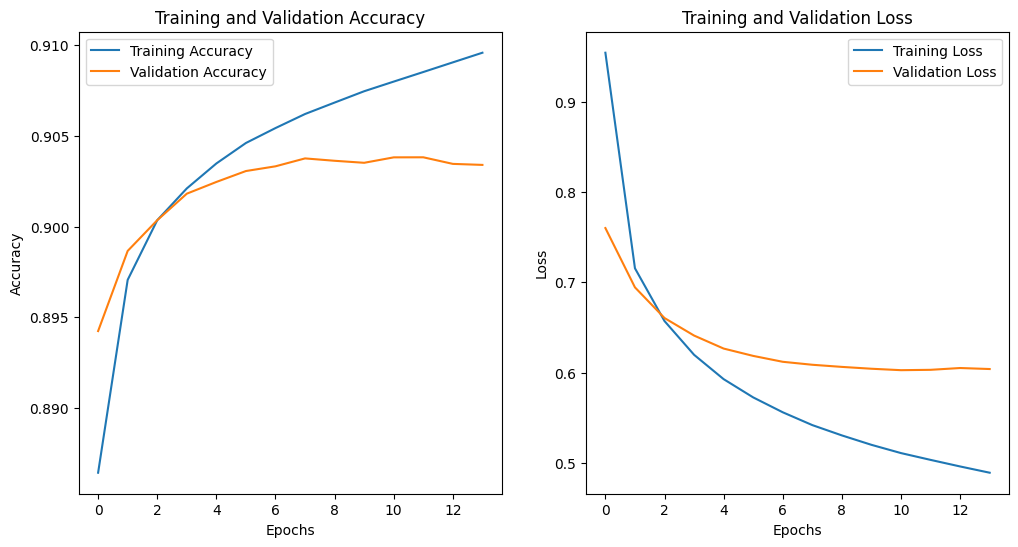

In [ ]:
# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Preprocessing input
input_padded = "bagaimana cara mempelajari jaringan komputer"  # Ganti dengan kalimat yang lebih sederhana

input_seq = tokenizer.texts_to_sequences([input_padded])
input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')

# Menghasilkan prediksi
predicted = model.predict(input_padded)

# Mengecek output prediksi
# print("Predicted probabilities:", predicted)

# Ambil kata dengan probabilitas tertinggi untuk setiap langkah
predicted_indices = np.argmax(predicted, axis=-1)

# Konversi indeks ke kata
predicted_words = [tokenizer.index_word.get(index, '') for index in predicted_indices[0]]

# Gabungkan kata-kata menjadi satu kalimat
parafrase = ' '.join(predicted_words).replace('  ', ' ').strip()

print("Parafrase:", parafrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Parafrase: bagaimana cara bisa jaringan komputer


In [ ]:
import nltk
# nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu  # Import BLEU score

# Kalimat referensi yang benar (misalnya, kalimat asli atau kalimat parafrase yang diinginkan)
reference = "bagaimana cara belajar jaringan komputer"  # Ganti dengan kalimat referensi yang sesuai

# Menghitung BLEU score
reference_tokens = reference.split()  # Tokenisasi kalimat referensi
predicted_tokens = parafrase.split()  # Tokenisasi kalimat hasil prediksi

# Menghitung BLEU score
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)

print("BLEU Score:", bleu_score)

BLEU Score: 1.1862800137389335e-154


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
# Menyimpan model
# model.save('paraphrase_LSTM_model.h5')


In [ ]:
datatest = {
    'question': [
        "Apa manfaat yoga untuk kesehatan?",
        "Bagaimana cara membuat kue cokelat?",
        "Mengapa penting untuk tidur cukup?",
        "Apa perbedaan antara data dan informasi?",
        "Apa yang harus dilakukan agar lebih produktif?",
        "Bagaimana cara menjaga kesehatan jantung?",
        "Apa saja manfaat belajar bahasa asing?",
        "Mengapa olahraga penting bagi tubuh?",
        "Apa itu ekonomi digital?",
        "Apa yang dimaksud dengan kecerdasan buatan?"
    ],
    'reference': [
        "Apa saja manfaat yoga bagi kesehatan tubuh?",
        "Apa langkah-langkah untuk membuat kue cokelat?",
        "Mengapa tidur yang cukup sangat penting untuk tubuh?",
        "Apa yang membedakan antara data dan informasi?",
        "Apa saja tips agar lebih produktif dalam bekerja?",
        "Apa yang harus dilakukan untuk menjaga kesehatan jantung?",
        "Apa keuntungan yang didapatkan dari belajar bahasa asing?",
        "Apa alasan olahraga sangat penting untuk kesehatan tubuh?",
        "Bagaimana ekonomi digital memengaruhi kehidupan kita?",
        "Apa itu AI dan bagaimana cara kerjanya?"
    ]
}

In [ ]:
# Membuat DataFrame
df2 = pd.DataFrame(datatest)

# Preprocessing data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df2['question'].tolist() + df2['reference'].tolist())  # Gabungkan kedua kolom untuk pelatihan tokenizer
max_length = max(df2['question'].apply(lambda x: len(x.split())).max(),
                 df2['reference'].apply(lambda x: len(x.split())).max())

# Tokenisasi input dan referensi
question_seq = tokenizer.texts_to_sequences(df2['question'].tolist())
reference_seq = tokenizer.texts_to_sequences(df2['reference'].tolist())

question_padded = pad_sequences(question_seq, maxlen=max_length, padding='post')
reference_padded = pad_sequences(reference_seq, maxlen=max_length, padding='post')

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('paraphrase_LSTM_model.h5')#'best_model_LSTM_0.9040.keras')

In [ ]:
# Fungsi untuk memprediksi parafrase
def predict_paraphrase(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')
    prediction = model.predict(input_padded)

    # Ambil prediksi dengan nilai tertinggi (berdasarkan probabilitas)
    predicted_tokens = np.argmax(prediction, axis=-1)[0]

    # Mengonversi kembali token menjadi teks
    predicted_text = tokenizer.sequences_to_texts([predicted_tokens])[0]
    return predicted_text

# Menggunakan SmoothingFunction untuk BLEU score
smoothing = SmoothingFunction().method1

# Melakukan prediksi dan menghitung BLEU score untuk setiap kalimat dalam DataFrame
for i in range(len(df2)):
    input_question = df2['question'][i]
    reference_paraphrase = df2['reference'][i]

    # Prediksi parafrase
    predicted_paraphrase = predict_paraphrase(input_question)

    # Tokenisasi referensi dan hasil prediksi untuk BLEU score
    reference_tokens = tokenizer.texts_to_sequences([reference_paraphrase])[0]
    predicted_tokens = tokenizer.texts_to_sequences([predicted_paraphrase])[0]

    # Menghitung BLEU score
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens, smoothing_function=smoothing)

    # Menampilkan hasil
    print(f"Pertanyaan: {input_question}")
    print(f"Parafrase yang diprediksi: {predicted_paraphrase}")
    print(f"Referensi: {reference_paraphrase}")
    print(f"BLEU score: {bleu_score:.4f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Pertanyaan: Apa manfaat yoga untuk kesehatan?
Parafrase yang diprediksi: apa informasi tubuh untuk
Referensi: Apa saja manfaat yoga bagi kesehatan tubuh?
BLEU score: 0.0451
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Pertanyaan: Bagaimana cara membuat kue cokelat?
Parafrase yang diprediksi: apa untuk untuk kue kue kue kue
Referensi: Apa langkah-langkah untuk membuat kue cokelat?
BLEU score: 0.0435
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Pertanyaan: Mengapa penting untuk tidur cukup?
Parafrase yang diprediksi: kesehatan dilakukan untuk tidur penting
Referensi: Mengapa tidur yang cukup sangat penting untuk tubuh?
BLEU score: 0.0388
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Pertanyaan: Apa perbedaan antara data dan informasi?
Parafrase yang diprediksi: apa jantung cara data data
Referensi: Apa yang membedakan an

In [ ]:
# Preprocessing input
input_padded = "sehat itu mahal"  # Ganti dengan kalimat yang lebih sederhana

input_seq = tokenizer.texts_to_sequences([input_padded])
input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')

# Menghasilkan prediksi
predicted = model.predict(input_padded)

# Mengecek output prediksi
# print("Predicted probabilities:", predicted)

# Ambil kata dengan probabilitas tertinggi untuk setiap langkah
predicted_indices = np.argmax(predicted, axis=-1)

# Konversi indeks ke kata
predicted_words = [tokenizer.index_word.get(index, '') for index in predicted_indices[0]]

# Gabungkan kata-kata menjadi satu kalimat
parafrase = ' '.join(predicted_words).replace('  ', ' ').strip()

print("Parafrase:", parafrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Parafrase: kesehatan


In [ ]:
# Kalimat referensi yang benar (misalnya, kalimat asli atau kalimat parafrase yang diinginkan)
reference = "kesehatan itu mahal"  # Ganti dengan kalimat referensi yang sesuai

# Menghitung BLEU score
reference_tokens = reference.split()  # Tokenisasi kalimat referensi
predicted_tokens = parafrase.split()  # Tokenisasi kalimat hasil prediksi

# Menghitung BLEU score
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)

print("BLEU Score:", bleu_score)

BLEU Score: 2.4655814830110698e-232


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
# Preprocessing input
input_padded = "kenapa kita harus belajar"  # Ganti dengan kalimat yang lebih sederhana

input_seq = tokenizer.texts_to_sequences([input_padded])
input_padded = pad_sequences(input_seq, maxlen=max_length, padding='post')

# Menghasilkan prediksi
predicted = model.predict(input_padded)

# Mengecek output prediksi
# print("Predicted probabilities:", predicted)

# Ambil kata dengan probabilitas tertinggi untuk setiap langkah
predicted_indices = np.argmax(predicted, axis=-1)

# Konversi indeks ke kata
predicted_words = [tokenizer.index_word.get(index, '') for index in predicted_indices[0]]

# Gabungkan kata-kata menjadi satu kalimat
parafrase = ' '.join(predicted_words).replace('  ', ' ').strip()

print("Parafrase:", parafrase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Parafrase: kesehatan harus antara


In [ ]:
# Kalimat referensi yang benar (misalnya, kalimat asli atau kalimat parafrase yang diinginkan)
reference = "mengapa kita harus belajar"  # Ganti dengan kalimat referensi yang sesuai

# Menghitung BLEU score
reference_tokens = reference.split()  # Tokenisasi kalimat referensi
predicted_tokens = parafrase.split()  # Tokenisasi kalimat hasil prediksi

# Menghitung BLEU score
bleu_score = sentence_bleu([reference_tokens], predicted_tokens)

print("BLEU Score:", bleu_score)

BLEU Score: 9.918892480173173e-232


In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    filepath='best_model_2_LSTM_{val_accuracy:.4f}.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' because we want the highest val_accuracy
    verbose=1
)
# Early Stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(X_padded, y_padded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint])
model.summary()

Epoch 1/50
3352/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8812 - loss: 1.2830
Epoch 1: val_accuracy improved from -inf to 0.89419, saving model to best_model_2_LSTM_0.8942.keras
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 361s 106ms/step - accuracy: 0.8812 - loss: 1.2828 - val_accuracy: 0.8942 - val_loss: 0.7419
Epoch 2/50
3352/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8952 - loss: 0.7224
Epoch 2: val_accuracy improved from 0.89419 to 0.89882, saving model to best_model_2_LSTM_0.8988.keras
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 354s 106ms/step - accuracy: 0.8952 - loss: 0.7224 - val_accuracy: 0.8988 - val_loss: 0.6772
Epoch 3/50
3352/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8986 - loss: 0.6620
Epoch 3: val_accuracy improved from 0.89882 to 0.90074, saving model to best_model_2_LSTM_0.9007.keras
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 343s 94ms/step - accuracy: 0.8986 - loss: 0.6620 - val_accuracy: 0.9007 - val_loss: 0.6440
Epoch 4/50
3352/3353 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - ac

In [ ]:
# Melakukan prediksi dan menghitung BLEU score untuk setiap kalimat dalam DataFrame
for i in range(len(df2)):
    input_question = df2['question'][i]
    reference_paraphrase = df2['reference'][i]

    # Prediksi parafrase
    predicted_paraphrase = predict_paraphrase(input_question)

    # Tokenisasi referensi dan hasil prediksi untuk BLEU score
    reference_tokens = tokenizer.texts_to_sequences([reference_paraphrase])[0]
    predicted_tokens = tokenizer.texts_to_sequences([predicted_paraphrase])[0]

    # Menghitung BLEU score
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens, smoothing_function=smoothing)

    # Menampilkan hasil
    print(f"Pertanyaan: {input_question}")
    print(f"Parafrase yang diprediksi: {predicted_paraphrase}")
    print(f"Referensi: {reference_paraphrase}")
    print(f"BLEU score: {bleu_score:.4f}")
    print("-" * 50)

In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    filepath='best_model_2_LSTM_{val_accuracy:.4f}.keras',  # Filepath to save the model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='max',                # 'max' because we want the highest val_accuracy
    verbose=1
)
# Early Stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(X_padded, y_padded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint])
model.summary()